# Предсказание финального места в игре PUBG

Работу выполнили студенты 2 курса Высшей школы ИТИС Хабибрахманов Рустем и Хамдамов Отабек, группа 11-811.

**Описание**: в игре PUBG в каждом матче играет до 100 игроков. Игроки могут быть в командах, которые получают рейтинг в конце игры на основе того, сколько других команд еще живы и когда они выбывают. В игре игроки могут подбирать различные боеприпасы, оживлять сбитых, но не выбитых товарищей по команде, управлять транспортными средствами, плавать, бегать, стрелять.
 
 **Цель**: создать модель, которая предсказывает финальное расположение игроков на основе их статистики, по шкале 1 (первое место) до 0 (последнее место).
 
 Ссылка на датасет: https://www.kaggle.com/c/pubg-finish-placement-prediction/data

### Загрузим данные

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,  cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [2]:
train_df = pd.read_csv(r'train_V2.csv')
test_df = pd.read_csv(r'test_V2.csv')
train_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


**Описание датасета**:

**Id** - идентификатор игрока.

**groupId** - идетнификатор группы для одного матча. Если одна и та же группа игроков играет в разных матчах, у них каждый раз будет другой groupId.

**matchId** - идентификатор матча.

**assists** - количество вражеских игроков, которых этот игрок повредил и которые были убиты товарищами по команде.

**boosts** - количество используемых элементов усиления.

**damageDealt** - общий нанесенный урон.

**DBNOs** - количество выбитых вражеских игроков.

**headshotKills** - количество вражеских игроков, убитых выстрелами в голову.

**heals** - количество используемых лечебных предметов.

**killPlace** - рейтинг в матче по количеству убитых вражеских игроков.

**killPoints** - рейтинг игрока на основе убийств.

**kills** - количество убитых вражеских игроков.

**killStreaks** - максимальное количество вражеских игроков, убитых за короткий промежуток времени.

**longestKill** - самое большое расстояние между игроком и игроком, убитым в момент смерти.

**matchDuration** - длительность матча в секундах.

**matchType** - строка, идентифицирующая игровой режим. Стандартные режимы - "solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp” и "squad-fpp"

**maxPlace** - наихудшее занятое место за все время

**numGroups** - количество групп, для которых у нас есть данные в матче.

**rankPoints** - Эло-подобный рейтинг игрока.

**revives** - количество раз, когда этот игрок оживлял товарищей по команде.

**rideDistance** - общее расстояние, пройденное в транспортных средствах, измеряемое в метрах.

**roadKills** - количество убийств, совершаемых в автомобиле.

**swimDistance** - общее расстояние, пройденное плаванием, измеряемое в метрах.

**teamKills** - количество раз, когда этот игрок убивал товарища по команде.

**vehicleDestroys** - количество уничтоженных транспортных средств.

**walkDistance** - общее расстояние, пройденное пешком, измеряемое в метрах.

**weaponsAcquired** - количество подобранного оружия.

**winPoints** - рейтинг игрока, основанный на победах (похож на Эло-рейтинг).

**winPlacePerc** - процент выйгрыша

In [3]:
train_df.shape

(4446966, 29)

Количетсво строк – 4 446 966

Количество столбцов – 29

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Проверим данные на сбалансированность

Выборку разделим по winPlacePerc на больше 0.5 и меньше 0.5 и посмотрим на их количество

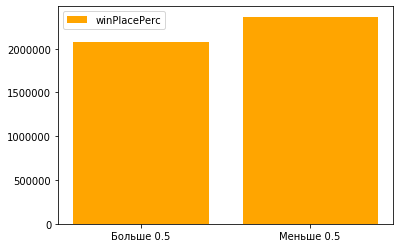

In [64]:
over = len(train_df[train_df['winPlacePerc'] >= 0.5])
under = len(train_df[train_df['winPlacePerc'] < 0.5])

plt.bar(['Больше 0.5', 'Меньше 0.5'], [over, under], label = 'winPlacePerc', color = 'orange')
plt.legend()
plt.show()

Мы видим, что выборка сбалансированна.

### Проверим выборку наличие нулевых строк

In [4]:
train_df.isnull().any().any()

True

In [5]:
train_df = train_df.dropna()
train_df.isnull().any().any()

False

### Проведем корреляционный анализ

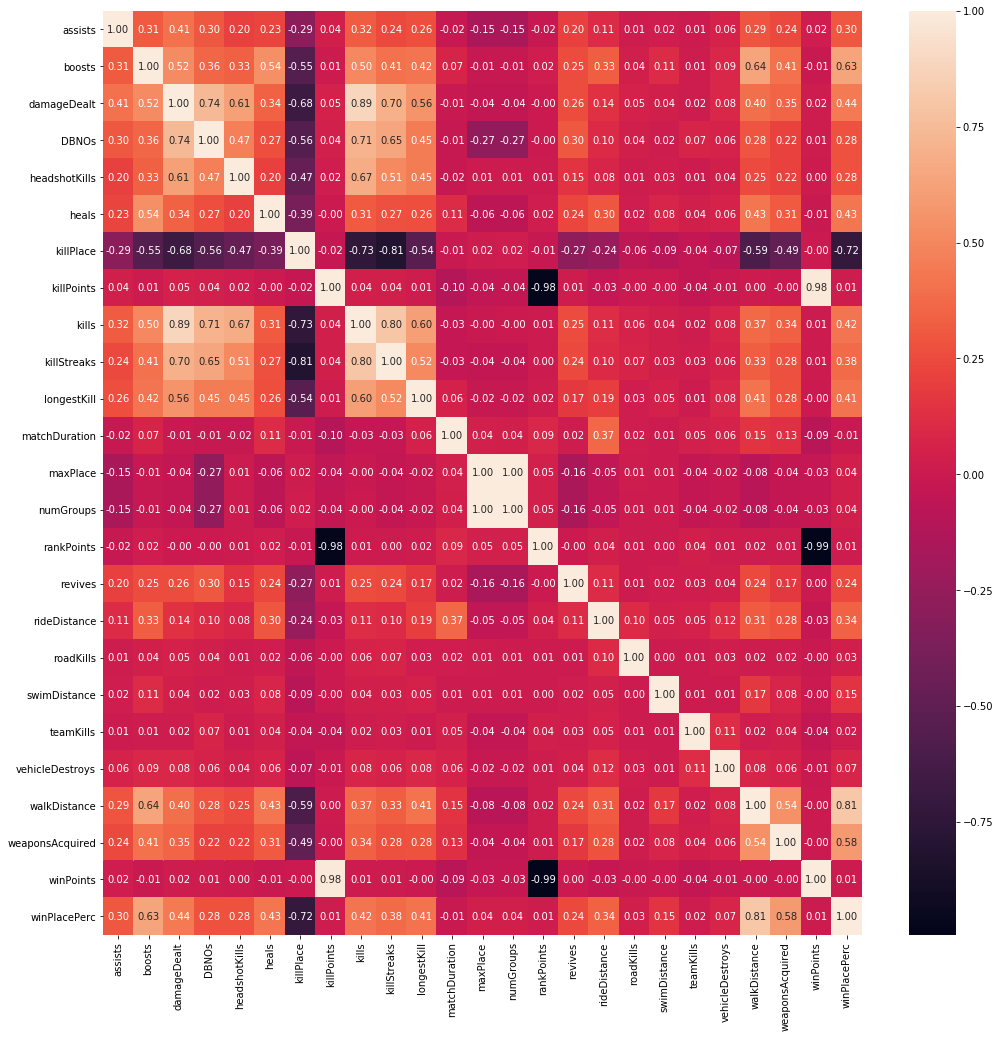

In [6]:
plt.subplots(figsize=(17, 17))
sns.heatmap(train_df.corr(), annot=True, fmt= '.2f')
plt.show()

**Признаки с наибольшей корреляцией по отношению к winPlacePerc:**

 1) walkDistance (0.81)
 
 2) killPlace (-0.72)
 
 3) boosts (0.63)
 
 4) weaponsAcquired (0.58)
 
 5) damageDealt (0.44)
 
Из вышеперечисленного можно сделать вывод, что на процент победы больше всего влияет дистанция, пройденная игроком, и рейтинг в матче по количеству убитых игроков. Пройденная дистанция показывает время, которое прожил игрок. Чем дольше живет игрок, тем выше его шансы на победу и так как он постоянно двигается, то и его пройденное расстояние увеличивается. Рейтинг по убийствам имеет отрицательную корреляцию, потому что меньшее число означает больше убийств. 

### Удалим категориальные данные 

Удалим столбцы "id", "matchId", "groupId" "matchType", так как они нам не понадобятся и разделим выборку на обучающую и тестовую.

In [7]:
target = 'winPlacePerc'
features = list(train_df.columns)
features.remove("Id")
features.remove("matchId")
features.remove("groupId")
features.remove("matchType")

Y_train = np.array(train_df[target])
features.remove(target)
X_train = train_df[features]
X_test = test_df[features]

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.4, random_state=1)

### Random Forest 

In [8]:
RF = RandomForestRegressor(n_estimators=30, max_features = 0.5, n_jobs = -1)

In [9]:
RF.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

**Посмотрим результаты**

Так как у нас регрессия, будем оценивать по 4 метрикам: score, MAE, MSE, RMSE.

In [14]:
print("Точность на тестовой выборке - ", RF.score(X_test, Y_test))
print("MAE - ", metrics.mean_absolute_error(RF.predict(X_test), Y_test))
print("MSE - ", metrics.mean_squared_error(RF.predict(X_test), Y_test))
print("RMSE - ", math.sqrt(metrics.mean_squared_error(RF.predict(X_test), Y_test)))

Точность на тестовой выборке -  0.9258128691244683
MAE -  0.05928125522959934
MSE -  0.007008514186111907
RMSE -  0.08371686918484175


### Gradient Boosting

In [15]:
GB = GradientBoostingRegressor(n_estimators=100,learning_rate=0.8)

In [16]:
GB.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.8, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим результаты**

In [17]:
print("Точность на тестовой выборке - ", GB.score(X_test, Y_test))
print("MAE - ", metrics.mean_absolute_error(GB.predict(X_test), Y_test))
print("MSE - ", metrics.mean_squared_error(GB.predict(X_test), Y_test))
print("RMSE - ", math.sqrt(metrics.mean_squared_error(GB.predict(X_test), Y_test)))

Точность на тестовой выборке -  0.9195573554199195
MAE -  0.06237206428945739
MSE -  0.007599477282033539
RMSE -  0.08717498082611512


### Decision Tree

In [18]:
DT = DecisionTreeRegressor(criterion='mse', max_depth = 20)

In [19]:
DT.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Посмотрим результаты**

In [20]:
print("Точность на тестовой выборке - ", DT.score(X_test, Y_test))
print("MAE - ", metrics.mean_absolute_error(DT.predict(X_test), Y_test))
print("MSE - ", metrics.mean_squared_error(DT.predict(X_test), Y_test))
print("RMSE - ", math.sqrt(metrics.mean_squared_error(DT.predict(X_test), Y_test)))

Точность на тестовой выборке -  0.9012909794984764
MAE -  0.06639555545894339
MSE -  0.009325115586998781
RMSE -  0.09656663806407874


### Linear Regression

In [28]:
LR = LinearRegression(n_jobs = -1)

In [29]:
LR.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

**Посмотрим результаты**

In [30]:
print("Точность на тестовой выборке - ", LR.score(X_test, Y_test))
print("MAE - ", metrics.mean_absolute_error(LR.predict(X_test), Y_test))
print("MSE - ", metrics.mean_squared_error(LR.predict(X_test), Y_test))
print("RMSE - ", math.sqrt(metrics.mean_squared_error(LR.predict(X_test), Y_test)))

Точность на тестовой выборке -  0.8304687393830258
MAE -  0.09263412107683969
MSE -  0.016015746006095715
RMSE -  0.12655333265503407


### Заключение

In [37]:
table = [["Random Forest",0.9258128691244683 ,0.05928125522959934 ,0.007008514186111907,0.08371686918484175],
         ["Gradient Boosting",0.9195573554199195 ,0.06237206428945739,0.007599477282033539,0.08717498082611512],
         ["Decision Tree", 0.9012909794984764, 0.06639555545894339,0.009325115586998781,0.09656663806407874],
         ["Linear Regression", 0.8304687393830258, 0.09263412107683969,0.016015746006095715,0.12655333265503407]]
pd.DataFrame(table, columns=["Алгоритм","score", "MAE", "MSE", "RMSE"])

,Алгоритм,score,MAE,MSE,RMSE
0,Random Forest,0.925813,0.059281,0.007009,0.083717
1,Gradient Boosting,0.919557,0.062372,0.007599,0.087175
2,Decision Tree,0.901291,0.066396,0.009325,0.096567
3,Linear Regression,0.830469,0.092634,0.016016,0.126553


По оценкам в таблице видно, что с задачей хуже всего справилась Linear Regression. На 2 и 3 месте расположись Gradient Boosting и Decision Tree соответсвенно. Random Forest показал наилучший результат.